In [1]:
# -------------------------------------------
# Multi-Output Forecasting with XGBoost
# -------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [2]:
# Cell 2: Load dataset
df = pd.read_csv("../Dataset/nasa_power_prepared_data.csv")
df = df.sort_values("date")
TARGET_COL = "t2m_forecast_7d"

In [3]:
LOOKAHEAD = 7
for i in range(1, LOOKAHEAD+1):
    df[f"t2m_day+{i}"] = df[TARGET_COL].shift(-i)

In [5]:
# Cell 3: Define selected features (จากขั้นตอน feature selection)
top_features = [
    'tsoil3', 'tsoil2', 'month', 'tsoil1', 'ts', 't2m',
    'tsurf', 'tsoil4', 't10m', 't10m_max', 't2m_max',
    't2m_min', 't10m_min', 'ts_min', 'ts_max'
]

LOOKBACK = 30  # ลองปรับเป็น 14, 30, 60 เพื่อดูผล
for i in range(1, LOOKBACK+1):
    for f in top_features:
        df[f"{f}_lag{i}"] = df[f].shift(i)


C:\Users\user\AppData\Local\Temp\ipykernel_26468\2498780776.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{f}_lag{i}"] = df[f].shift(i)
C:\Users\user\AppData\Local\Temp\ipykernel_26468\2498780776.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{f}_lag{i}"] = df[f].shift(i)
C:\Users\user\AppData\Local\Temp\ipykernel_26468\2498780776.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

In [6]:
# -------------------------------------------
# 4. เตรียม Dataset
# -------------------------------------------
lag_features = [c for c in df.columns if "lag" in c]
target_cols = [f"t2m_day+{i}" for i in range(1, LOOKAHEAD+1)]

dataset = df[lag_features + target_cols].dropna()
X = dataset[lag_features]
Y = dataset[target_cols]

print(f"Final dataset shape: X={X.shape}, Y={Y.shape}")

Final dataset shape: X=(16348, 450), Y=(16348, 7)


In [7]:
# -------------------------------------------
# 5. Train/Test Split แบบ Time-Series
# -------------------------------------------
train_size = int(len(X) * 0.8)  # 80% train, 20% test
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
Y_train, Y_test = Y.iloc[:train_size], Y.iloc[train_size:]

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (13078, 450), Test size: (3270, 450)


In [8]:
# -------------------------------------------
# 6. Multi-Output Model (XGBoost)
# -------------------------------------------
xgb_params = {
    "n_estimators": 500,
    "max_depth": 6,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_jobs": -1
}

model = MultiOutputRegressor(XGBRegressor(**xgb_params))
model.fit(X_train, Y_train)

preds = model.predict(X_test)

In [11]:
# -------------------------------------------
# 7. Evaluation
# -------------------------------------------
rmse_scores = []
for i in range(LOOKAHEAD):
    rmse = np.sqrt(mean_squared_error(Y_test.iloc[:, i], preds[:, i]))
    rmse_scores.append(rmse)
    print(f"Day+{i+1} RMSE: {rmse:.3f}")

print(f"\nAverage RMSE across 7 days: {np.mean(rmse_scores):.3f}")

Day+1 RMSE: 1.275
Day+2 RMSE: 1.298
Day+3 RMSE: 1.280
Day+4 RMSE: 1.276
Day+5 RMSE: 1.292
Day+6 RMSE: 1.284
Day+7 RMSE: 1.303

Average RMSE across 7 days: 1.287


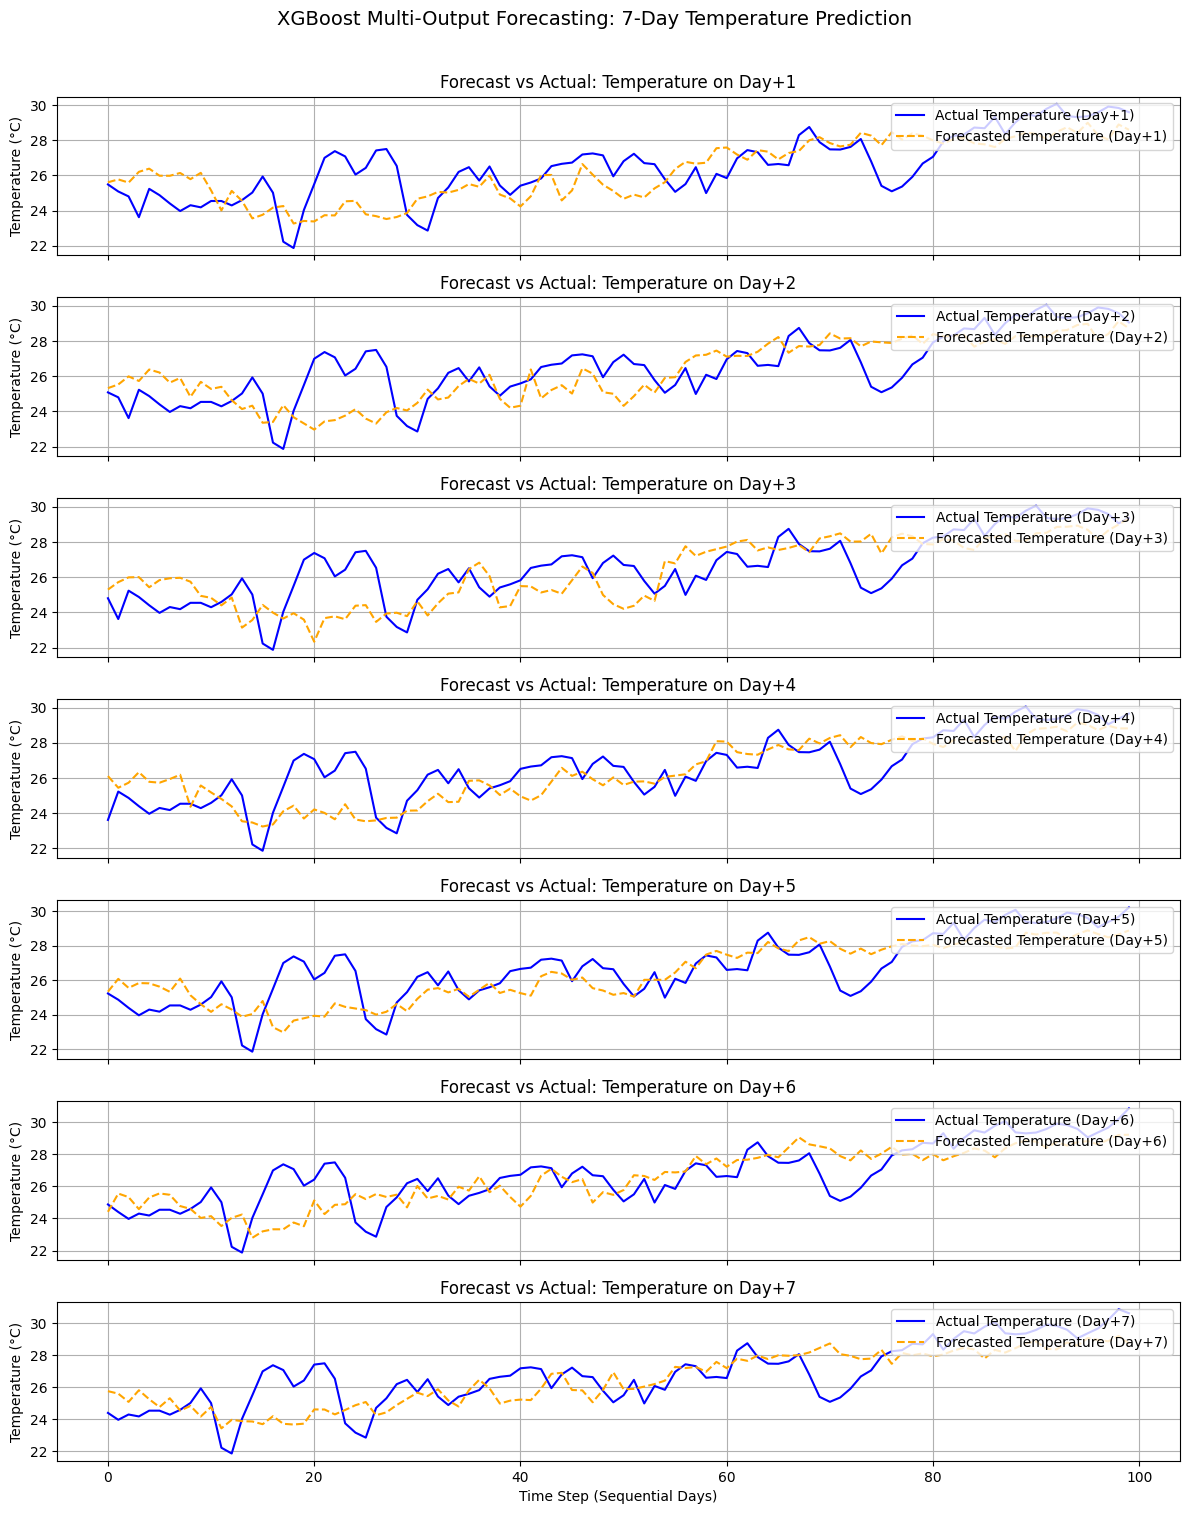

In [ ]:
# -------------------------------------------
# 8. Visualization: Forecast vs Actual Temperature (7-Day Horizon)
# -------------------------------------------
fig, axes = plt.subplots(LOOKAHEAD, 1, figsize=(12, 2.2 * LOOKAHEAD), sharex=True)

for i in range(LOOKAHEAD):
    axes[i].plot(Y_test.iloc[:, i].values[:100], label=f"Actual Temperature (Day+{i+1})", color='blue')
    axes[i].plot(preds[:100, i], linestyle="--", label=f"Forecasted Temperature (Day+{i+1})", color='orange')
    
    axes[i].set_title(f"Forecast vs Actual: Temperature on Day+{i+1}")
    axes[i].set_ylabel("Temperature (°C)")
    axes[i].legend(loc="upper right")
    axes[i].grid(True)

axes[-1].set_xlabel("Time Step (Sequential Days)")
plt.suptitle("XGBoost Multi-Output Forecasting: 7-Day Temperature Prediction", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()